In [1]:
%autosave 0

Autosave disabled


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import Holt, ExponentialSmoothing

Reading in our store data.

In [2]:
df = pd.read_csv('stores.csv', index_col=0)
df.head()

sale_amount item_brand                       item_name  \
sale_date                                                            
2013-01-01           13   Riceland  Riceland American Jazmine Rice   
2013-01-02           11   Riceland  Riceland American Jazmine Rice   
2013-01-03           14   Riceland  Riceland American Jazmine Rice   
2013-01-04           13   Riceland  Riceland American Jazmine Rice   
2013-01-05           10   Riceland  Riceland American Jazmine Rice   

            item_price           store_address  store_zipcode   store_city  \
sale_date                                                                    
2013-01-01        0.84  12125 Alamo Ranch Pkwy          78253  San Antonio   
2013-01-02        0.84  12125 Alamo Ranch Pkwy          78253  San Antonio   
2013-01-03        0.84  12125 Alamo Ranch Pkwy          78253  San Antonio   
2013-01-04        0.84  12125 Alamo Ranch Pkwy          78253  San Antonio   
2013-01-05        0.84  12125 Alamo Ranch Pkwy          78253  San Antonio   

           store_state  
sale_date               
2013-01-01          TX  
2013-01-02          TX  
2013-01-03          TX  
2013-01-04          TX  
2013-01-05          TX

In [3]:
df.index = pd.to_datetime(df.index)

Split before modeling. Human based split.

In [4]:
train = df.loc[:'2015']
validate = df.loc['2016']
test = df.loc['2017']

train.shape, validate.shape, test.shape

((547500, 8), (183000, 8), (182500, 8))

We need to perform an aggregation to have one point of the data per day. We can resample by the day and take the sum

In [6]:
day_train = train.resample('d').sales_total.sum()
day_val = validate.resample('d').sales_total.sum()
day_test = test.resample('d').sales_total.sum()

day_train.head()

AttributeError: 'DatetimeIndexResampler' object has no attribute 'sales_total'

Visualize

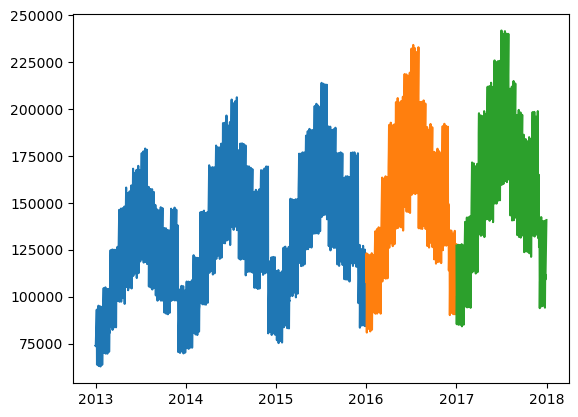

In [7]:
plt.plot(day_train)
plt.plot(day_val)
plt.plot(day_test)
plt.show()

Now that our data is properly split, let's try two different modeling approaches:
- One baseline model (rolling average)
- One non-baseline model (Holt's seasonal trend)

In [5]:
rolling = round(day_train.rolling(30).mean()[-1], 2)
rolling

NameError: name 'day_train' is not defined

In [9]:
preds = pd.DataFrame({'actual': day_val,
                      'rolling': rolling})

preds.head()

actual    rolling
sale_date                       
2016-01-01  107875.26  105739.12
2016-01-02  114330.43  105739.12
2016-01-03  123144.91  105739.12
2016-01-04   80873.97  105739.12
2016-01-05   95429.90  105739.12

In [10]:
def eval_preds(df, predictions, actual='actual'):
    
    return round(sqrt(mean_squared_error(df[actual], df[predictions])), 2)

In [11]:
eval_preds(preds, 'rolling')

57384.82

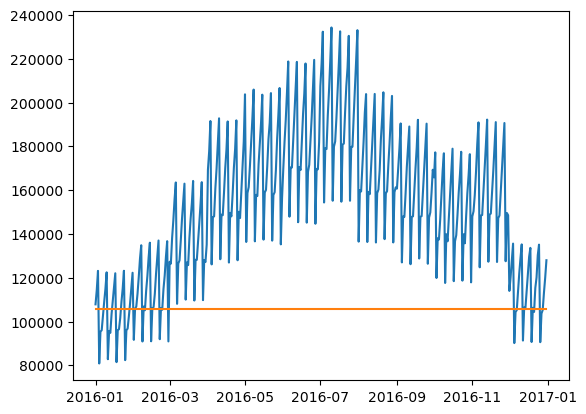

In [12]:
plt.plot(preds['actual'])
plt.plot(preds['rolling'])

In [13]:
hst_model = ExponentialSmoothing(day_train, seasonal_periods=365, trend='add', seasonal='add').fit()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [14]:
hst_model.forecast(day_val.shape[0])

2016-01-01    100114.134028
2016-01-02    108505.451715
2016-01-03    112492.190484
2016-01-04    120205.367567
2016-01-05    104386.511068
                  ...      
2016-12-27    133416.358399
2016-12-28    115047.490633
2016-12-29    105504.232098
2016-12-30    110782.483640
2016-12-31    111645.544104
Freq: D, Length: 366, dtype: float64

In [15]:
preds['hst'] = hst_model.forecast(day_val.shape[0])

In [16]:
eval_preds(preds, 'hst')

25942.97

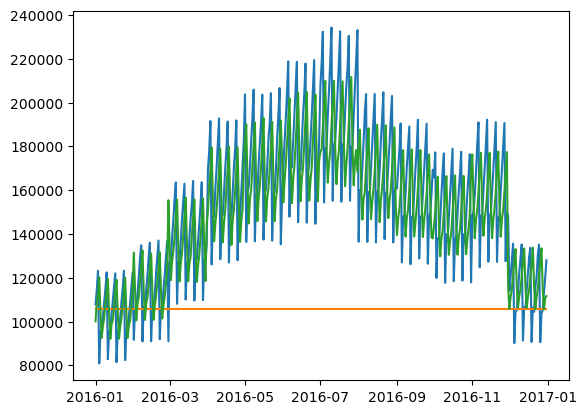

In [17]:
plt.plot(preds['actual'])
plt.plot(preds['rolling'])
plt.plot(preds['hst'])
plt.show()